In [1]:
%run setup.py

import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import scipy.interpolate

# Read in data

In [2]:
stars = pd.read_excel('../sample/samples.xlsx')


# subsets = 'all'
# subsets = 'ms'
subsets = 'rgb'

if subsets == 'all' :
    idx = (stars['ifmodelling']==1) & (~np.isin(stars['names'], ['ngc6791', 'ngc6819', 'binary']))
elif subsets == 'rgb' :
    idx = np.isin(stars['stage'], ['rgb']) & (stars['ifmodelling']==1) & (~np.isin(stars['names'], ['ngc6791', 'ngc6819', 'binary']))
else :
    idx = np.isin(stars['stage'], ['esg', 'lsg', 'ms']) & (stars['ifmodelling']==1) & (~np.isin(stars['names'], ['ngc6791', 'ngc6819', 'binary']))
    
stars = stars.loc[idx,:].reset_index(drop=True)

In [3]:
atm = '_eddin'
# atm = '_hopf'
stardata = np.load('../data/stellar_models_for_surface_optimisation{}.npy'.format(atm), allow_pickle=True)

In [4]:
Nmodels_star = np.array([stardata[istar]['Nmodels'] for istar in range(len(stardata))])
Nmodes_star = np.array([stardata[istar]['Nmodes'] for istar in range(len(stardata))])
kics_star = np.array([stardata[istar]['KIC'] for istar in range(len(stardata))])
# minchi2 = np.array([np.min(stardata[istar]['chi2']) for istar in range(len(stardata))])
# stardata = stardata[ (minchi2<20) & (Nmodels == 1000)]
# stardata = stardata[Nmodels]
# np.random.seed(0)
# stardata = np.random.choice(stardata, size=500, replace=False)
# Nstars = len(stardata)
stardata = stardata[(Nmodes_star >= 4) & np.isin(kics_star, stars['KIC'])] #(Nmodels_star == 200) & 
Nstars = len(stardata)

In [17]:
# surface_model = 'cubic' 
surface_model = 'combined'

In [6]:
Nstars

1084

In [7]:
Nmodes_max = np.max([stardata[istar]['Nmodes'] for istar in range(Nstars)])
Nmodels_max = np.max([stardata[istar]['Nmodels'] for istar in range(Nstars)])
chi2s_nonseis = np.zeros((Nmodels_max, Nstars))
gravs = np.ones((Nmodels_max, Nmodes_max, Nstars)) + 1.
Teffs = np.ones((Nmodels_max, Nmodes_max, Nstars)) + 5777.
fehs = np.ones((Nmodels_max, Nmodes_max, Nstars)) + 0. 
numaxs = np.ones((Nmodels_max, Nmodes_max, Nstars)) + 3090.
# f = (numax/nuac)^-1/I
# g = (numax/nuac)^3/I
# scale
# D1 = dfreq(numax) = a1 * f + a3 * g
# D2 = dfreq(scale*numax) = s^-1 * a1 * f + s^3 * a3 * g
# scale = 1.2
fs, gs, fs_d, gs_d  = [np.ones((Nmodels_max, Nmodes_max, Nstars)) for i in range(4)]
obs_freq_data, obs_efreq_data, mod_freq_data, mod_inertia_data, mod_efreq_sys = [np.ones((Nmodels_max, Nmodes_max, Nstars)) for i in range(5)]

Nmodes_imod_istar = np.ones((Nmodels_max, Nstars))
weights_imod_istar = np.ones((Nmodels_max, Nstars))
imode_imod_istar = np.zeros((Nmodels_max, Nmodes_max, Nstars))

idxf = np.zeros(Nstars, dtype=bool)

for istar in tqdm(range(Nstars)):
    Nmodes = stardata[istar]['Nmodes']
    Nmodels = stardata[istar]['Nmodels']
    mod_freq_data[0:Nmodels,0:Nmodes,istar] = stardata[istar]['mod_freqs'][:,:]
    mod_inertia_data[0:Nmodels,0:Nmodes,istar] = stardata[istar]['mod_inertias'][:,:]
    chi2s_nonseis[0:Nmodels,istar] = stardata[istar]['chi2_nonseis']

    for imod in range(Nmodels):
        obs_freq_data[imod,0:Nmodes,istar] = stardata[istar]['obs_freq']
        obs_efreq_data[imod,0:Nmodes,istar] = stardata[istar]['obs_efreq'] #np.ones(len(stardata[istar]['obs_freq'])) # 
        mod_efreq_sys[imod,0:Nmodes,istar] = stardata[istar]['mod_efreq_sys']
            
        fi = scipy.interpolate.interp1d(stardata[istar]['mod_freqs'][imod,:], 
              (stardata[istar]['mod_freqs'][imod,:]/stardata[istar]['numax_scaling'][imod])**3.0/stardata[istar]['mod_inertias'][imod,:], 
              kind='cubic', fill_value='extrapolate')
        gs[imod,:,istar] = fi(stardata[istar]['numax_scaling'][imod])
        # gs_d[imod,:,istar] = (fi(stardata[istar]['numax_scaling'][imod]+0.01) - fi(stardata[istar]['numax_scaling'][imod]-0.01) )/ (0.02)
        
        fi = scipy.interpolate.interp1d(stardata[istar]['mod_freqs'][imod,:], 
              (stardata[istar]['mod_freqs'][imod,:]/stardata[istar]['numax_scaling'][imod])**-1.0/stardata[istar]['mod_inertias'][imod,:], 
              kind='cubic', fill_value='extrapolate')
        fs[imod,:,istar] = fi(stardata[istar]['numax_scaling'][imod])
        # fs_d[imod,:,istar] = (fi(stardata[istar]['numax_scaling'][imod]+0.01) - fi(stardata[istar]['numax_scaling'][imod]-0.01) )/ (0.02)
        
        gravs[imod,:,istar] = stardata[istar]['g'][imod]
        Teffs[imod,:,istar] = stardata[istar]['Teff'][imod]
        fehs[imod,:,istar] = stardata[istar]['feh'][imod]
        numaxs[imod,:,istar] = stardata[istar]['numax_scaling'][imod]
    
    Nmodes_imod_istar[:, istar] = Nmodes
    weights_imod_istar[0:Nmodels, istar] = 1/Nmodels
    weights_imod_istar[Nmodels:, istar] = 0
    imode_imod_istar[:, 0:Nmodes, istar] = 1.
    idxf[istar] = np.sum(np.isfinite(gravs[:,:,istar]))

gravs, Teffs, fehs, numaxs = gravs[:,:,idxf], Teffs[:,:,idxf], fehs[:,:,idxf], numaxs[:,:,idxf]
fs, gs = fs[:,:,idxf], gs[:,:,idxf]
# fs_d, gs_d = fs_d[:,:,idxf], gs_d[:,:,idxf]
obs_freq_data, obs_efreq_data = obs_freq_data[:,:,idxf], obs_efreq_data[:,:,idxf]
mod_freq_data, mod_inertia_data = mod_freq_data[:,:,idxf], mod_inertia_data[:,:,idxf]
chi2s_nonseis = chi2s_nonseis[:,idxf]

weight_seis = 1. # 1/10.
weight_nonseis = 1.

100%|██████████| 1084/1084 [03:56<00:00,  4.58it/s]


In [8]:
mod_freq_data.shape, gravs.shape  # Nmodels_max, Nmodes_max, Nstars

((1500, 9, 1084), (1500, 9, 1084))

In [9]:
# make everything jax
mod_freq_data = jnp.asarray(mod_freq_data)
numaxs = jnp.asarray(numaxs)
mod_inertia_data = jnp.asarray(mod_inertia_data)
obs_freq_data = jnp.asarray(obs_freq_data)

Teffs = jnp.asarray(Teffs)
gravs = jnp.asarray(gravs)
fehs = jnp.asarray(fehs)

gs = jnp.asarray(gs)
fs = jnp.asarray(fs)

weights_imod_istar = jnp.asarray(weights_imod_istar)
imode_imod_istar = jnp.asarray(imode_imod_istar)

# Optimisation

In [18]:
# fitting model to be minimized
if surface_model == 'combined':
    def model_linear(thetas, *s): # use numax and scale*numax, feh
        D1 = thetas[0] * (gravs)**thetas[1] * (Teffs/5777.)**thetas[2] * (thetas[3]*fehs + 1) # surf corr at numax
        D2 = thetas[4] * (gravs)**thetas[5] * (Teffs/5777.)**thetas[6] * (thetas[7]*fehs + 1) # surf corr at scale*numax
        scale = 1.1

        surface_a3 = (scale**-1 * D1 - D2)/ ((scale**-1 - scale**3) *gs)
        surface_a1 = (scale**3 * D1 - D2)/ ((scale**3 - scale**-1) *fs)

        dfreq = (surface_a3 * (mod_freq_data/numaxs)**3.0 + surface_a1 * (mod_freq_data/numaxs)**-1.0)/mod_inertia_data
        mod_freq_corr_data = mod_freq_data + dfreq 

        chi2s_seis = jnp.mean((mod_freq_corr_data-obs_freq_data)**2.0/(obs_efreq_data**2. + mod_efreq_sys**2.), 
                              axis=1,
                              where=imode_imod_istar==1.)

        chi2 = chi2s_seis*weight_seis + chi2s_nonseis*weight_nonseis
        logP_star = jax.scipy.special.logsumexp(-chi2/2, axis=0, b=weights_imod_istar)

        return -jnp.nansum(logP_star)
    
else:
    def model_linear(thetas, *s): # use numax and scale*numax, feh
        D1 = thetas[0] * (gravs)**thetas[1] * (Teffs/5777.)**thetas[2] * (thetas[3]*fehs + 1) # surf corr at numax
        surface_a3 = D1/gs

        dfreq = (surface_a3*(mod_freq_data/numaxs)**3.0)/mod_inertia_data
        mod_freq_corr_data = mod_freq_data + dfreq 

        chi2s_seis = jnp.mean((mod_freq_corr_data-obs_freq_data)**2.0/(obs_efreq_data**2. + mod_efreq_sys**2.), 
                              axis=1,
                              where=imode_imod_istar==1.)

        chi2 = chi2s_seis*weight_seis + chi2s_nonseis*weight_nonseis
        logP_star = jax.scipy.special.logsumexp(-chi2/2, axis=0, b=weights_imod_istar)

        return -jnp.nansum(logP_star)
    
    
jit_model_linear = jax.jit(model_linear)

In [19]:
# combined
# paramsInit = jnp.array([-4.22, 1.0, -8.44, -0.41, #[-4.22, 0.99, -6.44, -0.41]
#                   -5.22, 1.0, -6.44, -0.41])
# paramsInit = jnp.array([-4.7303185 , 0.44954386, 2.2743673 , 0.66483986, -6.012368 , 0.50741553, 1.5869876 , 0.31649277])

# RGB:
# [-7.9282274 ,  1.2846141 , -6.3388844 , -0.01533486,
#  -8.494455  ,  1.1319928 , -5.3336873 , -0.30835932]
# [0.41842967, 0.02130897, 0.3689297 , 0.03597676, 
# 0.4364696 , 0.0170249 , 0.3102947 , 0.03083902]
    
# cubic    
paramsInit = jnp.array([-3.7443726, 1.0866573, -8.742777 , -1.3795667, -4.9891973, 1.0541984, -8.15369 , -1.3154854])
# jnp.array([-4.181521 , 0.95523196, -5.6379514 , -1.1099834 ])

# test if works
print(jit_model_linear(paramsInit))

# test if grad works
print(jax.grad(jit_model_linear)(paramsInit))

21918.754
[ 23.833319  128.26822     1.1044943  19.54561    -3.758421   50.535217
  18.362106  -18.811674 ]


In [12]:
import optax

def fit(params, optimizer):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(model_linear)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i  in range(5000):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 200 == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=2e-2)
params = fit(paramsInit, optimizer)

step 0, loss: 1750.8206787109375
step 200, loss: 1702.786376953125
step 400, loss: 1695.571044921875
step 600, loss: 1695.3759765625
step 800, loss: 1688.6497802734375
step 1000, loss: 1688.31298828125
step 1200, loss: 1688.312744140625
step 1400, loss: 1688.3126220703125
step 1600, loss: 1688.3126220703125
step 1800, loss: 1688.3126220703125
step 2000, loss: 1688.3135986328125
step 2200, loss: 1688.312744140625
step 2400, loss: 1688.3128662109375
step 2600, loss: 1688.312744140625
step 2800, loss: 1688.312744140625
step 3000, loss: 1688.3126220703125
step 3200, loss: 1688.3126220703125
step 3400, loss: 1688.312744140625
step 3600, loss: 1688.312744140625
step 3800, loss: 1688.353515625
step 4000, loss: 1688.312744140625
step 4200, loss: 1688.3153076171875
step 4400, loss: 1688.312744140625
step 4600, loss: 1688.312744140625
step 4800, loss: 1688.312744140625


In [20]:
# estimated values
# params = jnp.array([-4.181521 , 0.95523196, -5.6379514 , -1.1099834 ])
params = jnp.array([-3.7443726, 1.0866573, -8.742777 , -1.3795667, -4.9891973, 1.0541984, -8.15369 , -1.3154854])
params

DeviceArray([-3.7443726,  1.0866573, -8.742777 , -1.3795667, -4.9891973,
              1.0541984, -8.15369  , -1.3154854], dtype=float32)

In [14]:
# approx uncertainties from the Hessian matrix
err = jnp.diag(jnp.abs(jnp.linalg.inv(jax.hessian(jit_model_linear)(params))))**0.5
err

DeviceArray([0.09232494, 0.00926697, 0.17271471, 0.02324787], dtype=float32)

In [21]:
cov = jnp.linalg.inv(jax.hessian(jit_model_linear)(params))
diag = jnp.sqrt(jnp.diag(jnp.diag(cov)))
gaid = jnp.linalg.inv(diag)
corr = gaid @ cov @ gaid
corr

DeviceArray([[ 1.        , -0.34591866, -0.42900035, -0.21273926,
               0.9241423 , -0.2604225 , -0.45954454, -0.28338483],
             [-0.3458591 ,  1.0000001 , -0.692837  , -0.44314474,
              -0.34180248,  0.8650529 , -0.5254658 , -0.28083682],
             [-0.42906293, -0.6927884 ,  1.0000001 ,  0.56699   ,
              -0.37955612, -0.63358474,  0.8716615 ,  0.47360078],
             [-0.21277882, -0.44312456,  0.56700087,  1.        ,
              -0.21708858, -0.3642659 ,  0.47002703,  0.84788865],
             [ 0.9241334 , -0.34185594, -0.3794946 , -0.21705072,
               1.        , -0.3426243 , -0.44335365, -0.29162878],
             [-0.2603325 ,  0.865015  , -0.63361853, -0.36427385,
              -0.34254092,  0.9999999 , -0.68032914, -0.39284268],
             [-0.45962855, -0.5253842 ,  0.8716462 ,  0.47000483,
              -0.44343835, -0.68026066,  0.9999999 ,  0.5799363 ],
             [-0.2834451 , -0.28078708,  0.47359845,  0.84787863,
   

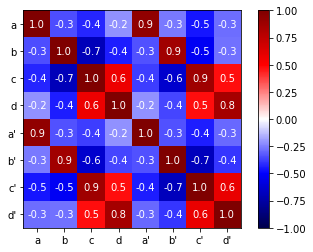

In [32]:
p = ['a', 'b', 'c', 'd', "a'", "b'", "c'", "d'"]

norm=matplotlib.colors.Normalize(vmin=-1, vmax=1)

plt.imshow(corr, cmap='seismic', norm=norm)
plt.xticks(range(0,8), p)
plt.yticks(range(0,8), p)
for i in range(8):
    for j in range(8):
        plt.text(i, j, '{:.1f}'.format(corr[i,j]), ha='center', va='center', color='white')
plt.colorbar()
plt.savefig('corr.png')

In [23]:
print('corr for b and c: {:.2f}'.format(corr[1,2]))
print('corr for b and d: {:.2f}'.format(corr[1,3]))
print('corr for c and d: {:.2f}'.format(corr[2,3]))

print("corr for a and a': {:.2f}".format(corr[0,1]))
print("corr for b and b': {:.2f}".format(corr[1,5]))
print("corr for c and c': {:.2f}".format(corr[2,6]))
print("corr for d and d': {:.2f}".format(corr[3,7]))

corr for b and c: -0.69
corr for b and d: -0.44
corr for c and d: 0.57
corr for a and a': -0.35
corr for b and b': 0.87
corr for c and c': 0.87
corr for d and d': 0.85


# Results for the combined surface correction model
## eddin atmosphere
### all sample
DeviceArray([-3.7443726,  1.0866573, -8.742777 , -1.3795667, 
             -4.9891973,  1.0541984, -8.15369  , -1.3154854], dtype=float32)

DeviceArray([0.13330452, 0.01283954, 0.22996646, 0.02094826, 
             0.13725656, 0.00977644, 0.18469958, 0.01802539], dtype=float32)
             
### RGB sample
DeviceArray([-3.8369734,  1.0976515, -8.83042  , -1.3841832, 
             -5.0435867,  1.0658274, -8.325036 , -1.3250351], dtype=float32)
             
DeviceArray([0.16418463, 0.01225858, 0.24061048, 0.02119218, 
             0.16585062, 0.00967092, 0.1921673 , 0.01829769], dtype=float32)

### MS+SG sample
DeviceArray([-3.715097  ,  0.6096728 , -1.6813153 , -0.08168457,
             -5.550722  ,  0.6479634 , -1.5653569 , -0.64631474],            dtype=float32)
   
DeviceArray([0.40209517, 0.0793009 , 0.82480085, 0.1394154 , 
             0.42107266, 0.05699116, 0.6225904 , 0.11118653], dtype=float32)

## hopf atmosphere
### all sample
DeviceArray([-4.730426  ,  0.44938794,  2.2742143 ,  0.6649345 ,
             -6.012242  ,  0.50756603,  1.5871831 ,  0.31629565],            dtype=float32)
             
DeviceArray([0.40055206, 0.05865041, 0.43102598, 0.11203981, 0.3800276 ,
             0.04579416, 0.35854703, 0.09796833], dtype=float32)

### RGB sample
DeviceArray([ -1.4532081 ,   0.87606186, -10.1614065 ,  -0.31404772,
              -2.310592  ,   0.89685166,  -9.446557  ,  -0.502116  ],            dtype=float32)
              
DeviceArray([0.03458241, 0.01137423, 0.19651969, 0.02047572, 0.05806956,
             0.00949883, 0.17697607, 0.01874554], dtype=float32)

### MS+SG sample
DeviceArray([-4.730426  ,  0.44938794,  2.2742143 ,  0.6649345 ,
             -6.012242  ,  0.50756603,  1.5871831 ,  0.31629565],            dtype=float32)
             
DeviceArray([0.40055206, 0.05865041, 0.43102598, 0.11203981, 0.3800276 ,
             0.04579416, 0.35854703, 0.09796833], dtype=float32)
             

# Results for the cubic surface correction model
## eddin atmosphere
### all sample
DeviceArray([-4.1485624,  0.9450712, -5.479969 , -1.0995963], dtype=float32)
             
DeviceArray([0.13009433, 0.01215709, 0.23190716, 0.02584277], dtype=float32)
             
### RGB sample
DeviceArray([-4.181521  ,  0.95523196, -5.6379514 , -1.1099834 ], dtype=float32)

DeviceArray([0.13015431, 0.01164923, 0.22260946, 0.02455296], dtype=float32)

### MS+SG sample
DeviceArray([-4.186023  ,  0.7813644 , -5.7118735 , -0.07299965], dtype=float32)

DeviceArray([0.3921687 , 0.06778456, 0.5822848 , 0.13034512], dtype=float32)

## hopf atmosphere
### all sample
DeviceArray([-3.064004  ,  0.96079797, -7.144836  , -0.8798956 ], dtype=float32)

DeviceArray([0.09832186, 0.00993515, 0.20343256, 0.02072822], dtype=float32)

### RGB sample

DeviceArray([-2.9030428 ,  0.97364545, -7.6786346 , -0.91186076], dtype=float32)


DeviceArray([0.09598602, 0.0110919 , 0.22213084, 0.02060322], dtype=float32)

### MS+SG sample

DeviceArray([-4.245544  ,  0.5040414 , -0.9813989 , -0.48889992], dtype=float32)

DeviceArray([0.27737832, 0.0578146 , 0.48618144, 0.08239575], dtype=float32)